In [24]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

# 基本用法

## 简单的示例

In [464]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph
from langgraph.graph import END
import operator

# 数据和逻辑
class AgentState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]

def nodeA(state):
    return {"messages": ["AAA"]}

def nodeB(state):
    return {"messages": ["BBB"]}

# 定义图
workflow = StateGraph(AgentState)

workflow.add_node("a", nodeA)
workflow.add_node("b", nodeB)

workflow.add_edge("a", "b")

workflow.set_entry_point("a")
workflow.set_finish_point("b")

app = workflow.compile()

# 运行
app.invoke({"messages": []})

{'messages': ['AAA', 'BBB']}

## 绘制ASCII图

In [470]:
app.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
    +---+      
    | a |      
    +---+      
      *        
      *        
      *        
    +---+      
    | b |      
    +---+      
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


## 绘制PNG图

In [ ]:
!pip install pygraphviz 

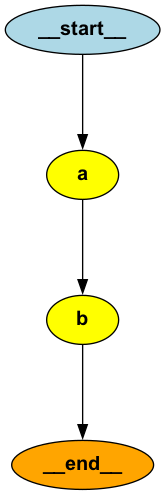

In [473]:
from IPython.display import Image
Image(app.get_graph().draw_png())

# MessageGraph 和 Chain 节点

## 定义图

In [487]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, MessageGraph, END
import operator

# 定义业务逻辑
def nodeA(state):
    return ["AAA"]

from langchain.llms.fake import FakeStreamingListLLM
llm = FakeStreamingListLLM(responses=["你好，我是一个模拟的大语言模型"])

# 定义图
workflow = MessageGraph()

workflow.add_node("a", nodeA)
workflow.add_node("b", llm)

workflow.add_edge("a", "b")
workflow.add_edge("b", END)

workflow.set_entry_point("a")

app = workflow.compile()

## 运行

In [488]:
for s in app.stream([]):
    print(s)

{'a': ['AAA']}
{'b': '你好，我是一个模拟的大语言模型'}
{'__end__': ['AAA', '你好，我是一个模拟的大语言模型']}


In [489]:
# RUN
async for chunk in app.astream_events([], version="v1"):
    # print(" "*10, chunk['event'], chunk['name'], chunk['tags'])
    if(chunk['event']=="on_chain_stream" and chunk['name'] in ["a", "b"]):
        print(">"*10, chunk['data']['chunk'])
    elif(chunk['event']=="on_chain_end" and chunk['name']=='LangGraph'):
        print(chunk['data'])

>>>>>>>>>> ['AAA']
>>>>>>>>>> 你
>>>>>>>>>> 好
>>>>>>>>>> ，
>>>>>>>>>> 我
>>>>>>>>>> 是
>>>>>>>>>> 一
>>>>>>>>>> 个
>>>>>>>>>> 模
>>>>>>>>>> 拟
>>>>>>>>>> 的
>>>>>>>>>> 大
>>>>>>>>>> 语
>>>>>>>>>> 言
>>>>>>>>>> 模
>>>>>>>>>> 型
{'output': {'__end__': ['AAA', '你好，我是一个模拟的大语言模型']}}


# StateGraph 和 Chain 节点

## 定义 Chain

In [491]:
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableParallel
from langchain.llms.fake import FakeStreamingListLLM

llm = FakeStreamingListLLM(responses=["""
"你好，我是一个模拟的大语言模型"
"""])

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", "你是一个有用的AI助手"),
    MessagesPlaceholder(variable_name="messages")
])

chain = RunnableParallel(
    messages = { "messages": lambda x: x['messages'] } | chat_prompt | llm
)

## 定义图

In [492]:
from typing import T, TypedDict, Annotated, Sequence, Union, Any, List, Iterator, AsyncIterator, Optional
from langchain_core.runnables import Runnable, RunnableConfig, RunnableSerializable
from langchain_core.outputs import Generation
from langchain_core.messages import BaseMessage, AnyMessage
from langgraph.graph import StateGraph, MessageGraph, END
import operator

from langchain_core.runnables import RunnablePassthrough

from langchain_core.messages import AIMessage
from langchain_core.runnables.utils import (
    AddableDict,
    AnyConfigurableField,
    ConfigurableField,
    ConfigurableFieldSpec,
    Input,
    Output,
)

def nodeA(state):
    return {"messages": ["AAA"]}

# 定义状态
Messages = Union[dict[list[AnyMessage]], list[AnyMessage], AnyMessage]

def add_messages(left: Messages, right: Messages) -> Messages:
    print("log: add_messages", "[", left, ",", right, "]")
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right

class AgentState(TypedDict):
    messages: Annotated[Sequence[str], add_messages]

# 定义图
workflow = StateGraph(AgentState)

workflow.add_node("__Node_A__", nodeA)
workflow.add_node("__Node_B__", chain)

workflow.add_edge("__Node_A__", "__Node_B__")
workflow.add_edge("__Node_B__", END)

workflow.set_entry_point("__Node_A__")

app = workflow.compile()

## 运行

In [493]:
# invoke
print("-"*20, "invoke", "-"*20)
print(app.invoke({"messages": [("user", "hi")]}))

# stream
print("-"*20, "stream", "-"*20)
for chunk in app.stream({"messages": [("user", "hi")]}):
    print(chunk)

# astream
print("-"*20, "astream", "-"*20)
async for chunk in app.astream({"messages": [("user", "hi")]}):
    print(chunk)

# astream_events
print("-"*20, "astream_events", "-"*20)
async for chunk in app.astream_events({"messages": [("user", "hi")]}, version="v1"):
    # print(" "*10, chunk['name'], chunk['event'], chunk['tags'])
    if(chunk['event']=="on_chain_stream" and chunk['name']=="__Node_B__"):        
        print(">"*10, chunk['data']['chunk'])
    elif(chunk['event']=="on_chain_end" and chunk['name']=='LangGraph'):
        print(chunk['data'])

-------------------- invoke --------------------
log: add_messages [ [('user', 'hi')] , ['AAA'] ]
log: add_messages [ [('user', 'hi'), 'AAA'] , 
"你好，我是一个模拟的大语言模型"
 ]
{'messages': [('user', 'hi'), 'AAA', '\n"你好，我是一个模拟的大语言模型"\n']}
-------------------- stream --------------------
log: add_messages [ [('user', 'hi')] , ['AAA'] ]
{'__Node_A__': {'messages': ['AAA']}}
log: add_messages [ [('user', 'hi'), 'AAA'] , 
"你好，我是一个模拟的大语言模型"
 ]
{'__Node_B__': {'messages': '\n"你好，我是一个模拟的大语言模型"\n'}}
{'__end__': {'messages': [('user', 'hi'), 'AAA', '\n"你好，我是一个模拟的大语言模型"\n']}}
-------------------- astream --------------------
log: add_messages [ [('user', 'hi')] , ['AAA'] ]
{'__Node_A__': {'messages': ['AAA']}}
log: add_messages [ [('user', 'hi'), 'AAA'] , 
"你好，我是一个模拟的大语言模型"
 ]
{'__Node_B__': {'messages': '\n"你好，我是一个模拟的大语言模型"\n'}}
{'__end__': {'messages': [('user', 'hi'), 'AAA', '\n"你好，我是一个模拟的大语言模型"\n']}}
-------------------- astream_events --------------------
log: add_messages [ [('user', 'hi')] , ['AAA'

# Tools-Calling V1：简单的框架

## 构建智能体框架

In [496]:
import json
import operator
from typing import Annotated, Sequence, TypedDict, Union

from langchain_core.language_models import LanguageModelLike
from langchain_core.messages import (
    BaseMessage,
    AIMessage,
    HumanMessage,
    ToolMessage
)
from langchain_core.runnables import RunnableLambda
from langchain_core.tools import BaseTool
from langchain_core.utils.function_calling import convert_to_openai_tool

from langgraph.graph import END, MessageGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation

def create_tool_calling_executor(
	model: LanguageModelLike,
	tools: Union[ToolExecutor, Sequence[BaseTool]],
):
	if isinstance(tools, ToolExecutor):
		tool_executor = tools
		tool_classes = tools.tools
	else:
		tool_executor = ToolExecutor(tools)
		tool_classes = tools

	reasoning_chain = (
		model.bind(tools=[convert_to_openai_tool(t) for t in tool_classes])
	)
	
	def should_continue(messages):
		last_message = messages[-1]
		if "tool_calls" not in last_message.additional_kwargs:
			return "end"
		else:
			return "continue"

	def _get_actions(messages):
		last_message = messages[-1]
		return (
			[
				ToolInvocation(
					tool=tool_call["function"]["name"],
					tool_input=json.loads(tool_call["function"]["arguments"]),
				)
				for tool_call in last_message.additional_kwargs["tool_calls"]
			],
			[
				tool_call["id"]
				for tool_call in last_message.additional_kwargs["tool_calls"]
			],
		)

	def call_tool(messages):
		actions, ids = _get_actions(messages)
		responses = tool_executor.batch(actions)
		assert len(actions) == len(responses), "The number of actions and responses should be the same"
		tool_messages = [
			ToolMessage(content=str(response), tool_call_id=id)
			for response, id in zip(responses, ids)
		]
		return tool_messages

	async def acall_tool(messages):
		actions, ids = _get_actions(messages)
		responses = await tool_executor.abatch(actions)
		tool_messages = [
			ToolMessage(content=str(response), tool_call_id=id)
			for response, id in zip(responses, ids)
		]
		return tool_messages

	workflow = MessageGraph()

	workflow.add_node("agent", reasoning_chain)
	workflow.add_node("action", RunnableLambda(call_tool, acall_tool))

	workflow.set_entry_point("agent")

	workflow.add_conditional_edges(
		"agent",
		should_continue,
		{
			"continue": "action",
			"end": END,
		},
	)

	workflow.add_edge("action", "agent")

	return workflow.compile()

## 定义工具集

In [515]:
from langchain.tools import BaseTool, StructuredTool, tool
from langchain.llms.fake import FakeStreamingListLLM

@tool
def search(query: str) -> str:
    """Look up things online."""
    return "LangChain-Chinese 是一个专门优化中文大语言模型在 langchain 中使用的模块。"

@tool
def talk_joke(query: str) -> str:
    """当别人要求你讲笑话时，你可以直接引用我讲的笑话"""
    llm = FakeStreamingListLLM(responses=["从前有一个笨蛋，最后笨死了。"])
    return llm.invoke(query)

tools = [search, talk_joke]

## 定义智能体

In [516]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0, streaming=True)

app = create_tool_calling_executor(model, tools)

## 运行

In [542]:
print("-"*20, "astream_events", "-"*20)
async for chunk in app.astream_events('给我讲一个笑话', version="v1"):
    # print(" "*10, chunk['name'], chunk['event'], chunk['tags'])
    if(chunk['event']=="on_chain_stream" and chunk['name'] in ["agent", "action"]):
        c = chunk['data']['chunk']
        if hasattr(c, 'content'):
            print(c.content, end="_")
        else:
            print("\n", c, "\n")
    elif(chunk['event']=="on_chain_end" and chunk['name']=='LangGraph'):
        print("\n")
        print(chunk['data'])

-------------------- astream_events --------------------
_______
 [ToolMessage(content='从前有一个笨蛋，最后笨死了。', tool_call_id='call_dUIcWuuZEA79H5FsqnseX91e')] 

_哈_哈_，_这_个_笑_话_有_点_冷_！_需要_我_再_给_你_讲_一个_吗_？__

{'output': {'__end__': ['给我讲一个笑话', AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_dUIcWuuZEA79H5FsqnseX91e', 'function': {'arguments': '{"query":"random"}', 'name': 'talk_joke'}, 'type': 'function'}]}), ToolMessage(content='从前有一个笨蛋，最后笨死了。', tool_call_id='call_dUIcWuuZEA79H5FsqnseX91e'), AIMessageChunk(content='哈哈，这个笑话有点冷！需要我再给你讲一个吗？')]}}


# Tools-Calling V2：单独处理 Chain

## 定义智能体框架

In [110]:
import json
import operator
from typing import Annotated, Sequence, TypedDict, Union

from langchain_core.language_models import LanguageModelLike
from langchain_core.messages import (
	BaseMessage,
	AIMessage,
	HumanMessage,
	ToolMessage
)
from langchain_core.runnables import RunnableLambda
from langchain_core.tools import BaseTool
from langchain_core.utils.function_calling import convert_to_openai_tool

from langgraph.graph import END, MessageGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation

def create_tool_calling_executor(
	model: LanguageModelLike,
	tools: Union[ToolExecutor, Sequence[BaseTool]],
	chains: dict,
):
	if isinstance(tools, ToolExecutor):
		tool_executor = tools
		tool_classes = tools.tools
	else:
		tool_executor = ToolExecutor(tools)
		tool_classes = tools

	reasoning_chain = (
		model.bind(tools=[convert_to_openai_tool(t) for t in tool_classes])
	)
	
	def should_continue(messages):
		last_message = messages[-1]
		if "tool_calls" not in last_message.additional_kwargs:
			return "end"
		else:
			tool_call = last_message.additional_kwargs["tool_calls"][0]
			tool_name = tool_call["function"]["name"]
			print("tool-name: ", tool_name)
			if tool_name in chains:
				print(f"log: call chain [{tool_name}]")
				return tool_name
			else:
				print(f"log: call tool [{tool_name}]")
				return "tools-callback"

	def _get_actions(messages):
		last_message = messages[-1]
		return (
			[
				ToolInvocation(
					tool=tool_call["function"]["name"],
					tool_input=json.loads(tool_call["function"]["arguments"]),
				)
				for tool_call in last_message.additional_kwargs["tool_calls"]
			],
			[
				tool_call["id"]
				for tool_call in last_message.additional_kwargs["tool_calls"]
			],
		)

	def call_tool(messages):
		actions, ids = _get_actions(messages)
		responses = tool_executor.batch(actions)
		assert len(actions) == len(responses), "The number of actions and responses should be the same"
		tool_messages = [
			ToolMessage(content=str(response), tool_call_id=id)
			for response, id in zip(responses, ids)
		]
		return tool_messages

	async def acall_tool(messages):
		actions, ids = _get_actions(messages)
		responses = await tool_executor.abatch(actions)
		tool_messages = [
			ToolMessage(content=str(response), tool_call_id=id)
			for response, id in zip(responses, ids)
		]
		return tool_messages

	workflow = MessageGraph()

	workflow.add_node("agent", reasoning_chain)
	workflow.add_node("action", RunnableLambda(call_tool, acall_tool))
	for chain_name in chains:
		workflow.add_node(chain_name, chains[chain_name])

	workflow.set_entry_point("agent")

	conditions = {
		"tools-callback": "action",
		"end": END,
	}
	for chain_name in chains:
		conditions[chain_name] = chain_name
	workflow.add_conditional_edges("agent", should_continue, conditions)

	workflow.add_edge("action", "agent")
	for chain_name in chains:
		workflow.add_edge(chain_name, END)

	return workflow.compile()

In [111]:
from langchain.tools import BaseTool, StructuredTool, tool
from langchain.chat_models.fake import FakeListChatModel

@tool
def search(query: str) -> str:
    """Look up things online."""
    return "LangChain-Chinese 是一个专门优化中文大语言模型在 langchain 中使用的模块。"

llm = FakeListChatModel(responses=['从前有一个笨蛋，最后笨死了。'])

@tool
def talk_joke(query: str) -> str:
    """当别人要求你讲笑话时，你可以直接引用我讲的笑话"""
    return llm.invoke(query)

tools = [search, talk_joke]
chains = {"talk_joke": llm}

In [112]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0, streaming=True)

app = create_tool_calling_executor(model, tools, chains)

In [113]:
print("-"*20, "astream_events", "-"*20)
async for chunk in app.astream_events('给我讲一个笑话', version="v1"):
    # print(" "*10, chunk['name'], chunk['event'], chunk['tags'])
    if(chunk['event']=="on_chain_stream" and chunk['name'] in ["agent", "action", "talk_joke"]):
        c = chunk['data']['chunk']
        if hasattr(c, 'content'):
            print(c.content, end="_")
        else:
            print(c)
    elif(chunk['event']=="on_chain_end" and chunk['name']=='LangGraph'):
        print("\n")
        print(chunk['data'])

-------------------- astream_events --------------------
_______tool-name:  talk_joke
log: call chain [talk_joke]
从_前_有_一_个_笨_蛋_，_最_后_笨_死_了_。_

{'output': {'__end__': ['给我讲一个笑话', AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_3S7M4VFvNMdvVjIRnAlZexpo', 'function': {'arguments': '{"query":"random"}', 'name': 'talk_joke'}, 'type': 'function'}]}), AIMessageChunk(content='从前有一个笨蛋，最后笨死了。')]}}


In [54]:
s = "('talk_joke',)"
m = re.search(r"(\w+)", s)
print(m.group(1))

talk_joke


# chat_agent_executor

In [2]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import chat_agent_executor
from langchain_core.messages import HumanMessage

tools = [TavilySearchResults(max_results=1)]
model = ChatOpenAI(streaming=True)

app = chat_agent_executor.create_tool_calling_executor(model, tools)

In [3]:
inputs = {"messages": [HumanMessage(content="霍金的生日是哪一天？")]}

In [ ]:
for chunk in app.stream(inputs):
    print(chunk)

In [ ]:
async for output in app.astream_log(inputs, include_types=["llm"]):
    # astream_log() yields the requested logs (here LLMs) in JSONPatch format
    for op in output.ops:
        if op["path"] == "/streamed_output/-":
            # this is the output from .stream()
            ...
            print(op["value"])
        elif op["path"].startswith("/logs/") and op["path"].endswith(
            "/streamed_output/-"
        ):
            # because we chose to only include LLMs, these are LLM tokens
            print(op["value"])

In [ ]:
async for chunk in app.astream_events(inputs, version="v1"):
    print("\n")
    print("-"*80)
    print(f"name: {chunk['name']}")
    print(f"tags: {chunk['tags']}")
    print(f"event: {chunk['event']}")
    if(chunk['event']=="on_chain_stream"):
        m = chunk['data']['chunk']
        if "messages" in m:
            for x in m["messages"]:
                print(x.content, end="|", flush=True)


# 从智能体中提取对话信息

您可以通过定义一个“记忆器”（通常可以是一个队列或者其他类型的数据结构，用于临时存储数据）来实现这个功能。这种方法允许您在服务器端持续将数据写入到这个记忆器中，同时客户端可以异步地读取这些数据，直到所有流式结果都被处理完毕。这种模式在处理实时数据流、日志监控或者其他需要实时数据更新的场景中非常有用。

以下是实现这一功能的大致步骤和示例代码：

步骤 1：定义记忆器
记忆器可以是一个简单的队列（如 Python 的 queue.Queue），用于在生产者（数据生成函数）和消费者（客户端请求处理函数）之间传递消息。

步骤 2：数据生成函数循环写入记忆器
您的数据生成函数（或者其他逻辑）会在循环中生成数据，并将这些数据写入到记忆器中。

步骤 3：客户端异步读取记忆器
通过一个特定的 API 端点，客户端可以开始读取记忆器中的数据。服务器端可以使用异步处理来实时发送记忆器中的数据给客户端，直到所有数据都被发送。

示例代码
```python
from fastapi import FastAPI, WebSocket
import asyncio
from typing import List

app = FastAPI()

# 定义一个简单的记忆器，这里使用列表模拟
memory = []

# 数据生成函数，模拟数据产生并写入记忆器
async def generate_data():
    for i in range(10):
        await asyncio.sleep(1)  # 模拟异步操作
        memory.append(f"Data {i}")  # 将数据写入记忆器

# WebSocket路由，客户端通过WebSocket连接读取数据
@app.websocket("/ws")
async def websocket_endpoint(websocket: WebSocket):
    await websocket.accept()
    # 启动数据生成任务，但不等待它完成
    task = asyncio.create_task(generate_data())
    while not task.done() or memory:  # 检查任务是否完成或记忆器中是否有数据
        if memory:  # 如果记忆器中有数据，则发送给客户端
            data_to_send = memory.pop(0)  # 获取记忆器中的第一个数据并发送
            await websocket.send_text(data_to_send)
        else:
            await asyncio.sleep(0.1)  # 等待更多数据生成
    await websocket.close()
```
在这个示例中，generate_data 函数模拟了数据生成过程，将数据逐个写入全局变量 memory 中。通过 WebSocket 连接，客户端可以实时地接收这些数据。服务器在有数据可发送时通过 WebSocket 向客户端发送数据，直到数据生成任务完成并且记忆器中的所有数据都被发送。

请注意，这里使用全局变量作为记忆器仅用于示